### Fine tuning ResNet50

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
import cv2

from sklearn.utils import shuffle

import visualize
reload(visualize)
from sklearn import svm

from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.svm import LinearSVC

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pickle

import sys


In [2]:
# keras libraries
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
import keras.backend as K
from keras.optimizers import SGD


Using TensorFlow backend.


In [3]:
# load images names, create a data frame with the columns [img name, label, and path]
file_names = glob.glob('NWPU-RESISC45/*/*')
file_names_df = [i.split('/')[1:] for i in file_names]
file_names_df = pd.DataFrame(file_names_df, columns=['label','img_name'])
file_names_df['full_img_path'] = file_names

In [3]:
# this stores the initial weights from the model to be tuned 
resnet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3), pooling='max')
# the model to be tuned
fine_tune_resnet50_model = ResNet50(include_top=True, weights=None, input_shape=(256,256,3),classes=45)
# this will copy the weights from the prev model after it gets fine tuned
feature_extractor_resnet50_model = ResNet50(include_top=False, weights=None, input_shape=(256,256,3), pooling='max')


In [5]:
# load all images
images = np.array(file_names_df['full_img_path'].apply(lambda i: cv2.imread(i)).tolist()).astype(np.float32)

In [6]:
# preprocess the images
preprocessed_imgs = resnet_preprocess_input(images)
labels = np.array(file_names_df['label'])

In [18]:
num_classes = 45
batch_size = 32 
nb_epoch = 3

In [8]:
#convert labels to one-hot encoded labels
le = LabelEncoder().fit(labels)
ohe = OneHotEncoder(sparse=False).fit(le.transform(labels).reshape(len(labels),1))

one_hot_labels = ohe.transform(le.transform(labels).reshape(len(labels),1))

In [19]:
accuracies = {}
confusion_matrices = {}

#fune tune, train and test for each train size settings for 5 times
for test_size in [.9, .8]:
    print 'test size (in percentage): '+str(test_size)
    sys.stdout.flush()
    
    accuracies[str(test_size)] = []
    confusion_matrices[str(test_size)] = []
    
    splitter = ShuffleSplit(n_splits=5, test_size=test_size, random_state=0)

    for train_index, test_index in tqdm(splitter.split(preprocessed_imgs)):
        
        # split data for deep learning fine tuning
        X_train, y_train = preprocessed_imgs[train_index], one_hot_labels[train_index]
        
        # set the weights to the pre-trained weights
        fine_tune_resnet50_model.set_weights(resnet50_model.get_weights())
        
        # renitialize the last layer (dense layer)
        session = K.get_session()
        fine_tune_resnet50_model.layers[-1].kernel.initializer.run(session=session)
        
        sgd = SGD(lr=0.001, decay=0.0005, momentum=0.9)
        fine_tune_resnet50_model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
        fine_tune_resnet50_model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, \
                  shuffle=True, verbose=0, validation_data=None)
        
        # end of fine tuning
        #########
        

        # set the weights to the fine-tuned model
        feature_extractor_resnet50_model.set_weights(fine_tune_resnet50_model.get_weights())
        
        
        # extract features for train and test
        X_train = feature_extractor_resnet50_model.predict(X_train)
        X_test = feature_extractor_resnet50_model.predict(preprocessed_imgs[test_index])
        
        y_train = labels[train_index]
        y_test = labels[test_index]
        
        svm = LinearSVC(random_state=0)
        svm.fit(X_train, y_train)
        
        y_hat = svm.predict(X_test)

        accuracy = accuracy_score(y_test, y_hat)
        cfnm = confusion_matrix(y_test, y_hat)
        
        accuracies[str(test_size)].append(accuracy)
        confusion_matrices[str(test_size)].append(cfnm)
        
                
    print np.mean(accuracies[str(test_size)])
    sys.stdout.flush()
    

test size (in percentage): 0.9


0it [00:00, ?it/s]

Epoch 1/3
3150/3150 [==============================] - 144s - loss: 2.2816 - acc: 0.4476   
Epoch 2/3
3150/3150 [==============================] - 137s - loss: 0.5269 - acc: 0.8838   
Epoch 3/3
3150/3150 [==============================] - 137s - loss: 0.2219 - acc: 0.9610   


1it [15:46, 946.36s/it]

Epoch 1/3
3150/3150 [==============================] - 144s - loss: 2.2144 - acc: 0.4508   
Epoch 2/3
3150/3150 [==============================] - 137s - loss: 0.5174 - acc: 0.8844   
Epoch 3/3
3150/3150 [==============================] - 137s - loss: 0.1999 - acc: 0.9689   


2it [31:20, 940.46s/it]

Epoch 1/3
3150/3150 [==============================] - 145s - loss: 2.2524 - acc: 0.4549   
Epoch 2/3
3150/3150 [==============================] - 137s - loss: 0.5155 - acc: 0.8863   
Epoch 3/3
3150/3150 [==============================] - 137s - loss: 0.1829 - acc: 0.9752   


3it [47:03, 941.12s/it]

Epoch 1/3
3150/3150 [==============================] - 144s - loss: 2.4139 - acc: 0.4168   
Epoch 2/3
3150/3150 [==============================] - 138s - loss: 0.5517 - acc: 0.8743   
Epoch 3/3
3150/3150 [==============================] - 137s - loss: 0.2121 - acc: 0.9657   


4it [1:02:55, 943.79s/it]

Epoch 1/3
3150/3150 [==============================] - 149s - loss: 2.3465 - acc: 0.4295   
Epoch 2/3
3150/3150 [==============================] - 137s - loss: 0.5764 - acc: 0.8714   
Epoch 3/3
3150/3150 [==============================] - 137s - loss: 0.2297 - acc: 0.9629   


5it [1:18:51, 946.26s/it]

0.853234567901
test size (in percentage): 0.8



0it [00:00, ?it/s]

Epoch 1/3
6300/6300 [==============================] - 282s - loss: 1.5883 - acc: 0.6049   
Epoch 2/3
6300/6300 [==============================] - 272s - loss: 0.3282 - acc: 0.9137   
Epoch 3/3
6300/6300 [==============================] - 271s - loss: 0.1316 - acc: 0.9751   


1it [22:03, 1323.60s/it]

Epoch 1/3
6300/6300 [==============================] - 277s - loss: 1.6349 - acc: 0.5841   
Epoch 2/3
6300/6300 [==============================] - 271s - loss: 0.3521 - acc: 0.9110   
Epoch 3/3
6300/6300 [==============================] - 271s - loss: 0.1315 - acc: 0.9757   


2it [43:54, 1317.41s/it]

Epoch 1/3
6300/6300 [==============================] - 277s - loss: 1.6143 - acc: 0.5973   
Epoch 2/3
6300/6300 [==============================] - 271s - loss: 0.3409 - acc: 0.9100   
Epoch 3/3
6300/6300 [==============================] - 271s - loss: 0.1271 - acc: 0.9749   


3it [1:05:44, 1314.69s/it]

Epoch 1/3
6300/6300 [==============================] - 278s - loss: 1.5429 - acc: 0.6105   
Epoch 2/3
6300/6300 [==============================] - 271s - loss: 0.3207 - acc: 0.9156   
Epoch 3/3
6300/6300 [==============================] - 271s - loss: 0.1265 - acc: 0.9741   


4it [1:27:34, 1313.70s/it]

Epoch 1/3
6300/6300 [==============================] - 278s - loss: 1.5525 - acc: 0.6149   
Epoch 2/3
6300/6300 [==============================] - 271s - loss: 0.3331 - acc: 0.9170   
Epoch 3/3
6300/6300 [==============================] - 271s - loss: 0.1297 - acc: 0.9762   


5it [1:49:28, 1313.66s/it]

0.890222222222


In [32]:
print 'accuracies of ResNet50 model'
for key in accuracies.keys():
    accuracy = np.mean(accuracies[key])
    print 'test size is '+key
    print 'accuracy for is '+str(accuracy)+' +/- '+str(np.std(accuracies[key]))

    print

accuracies of ResNet50 model
test size is 0.9
accuracy for is 0.853234567901 +/- 0.00111686870841

test size is 0.8
accuracy for is 0.890222222222 +/- 0.00164758540505



In [25]:
classes = file_names_df['label'].unique().tolist()
classes = sorted(classes)

Normalized confusion matrix


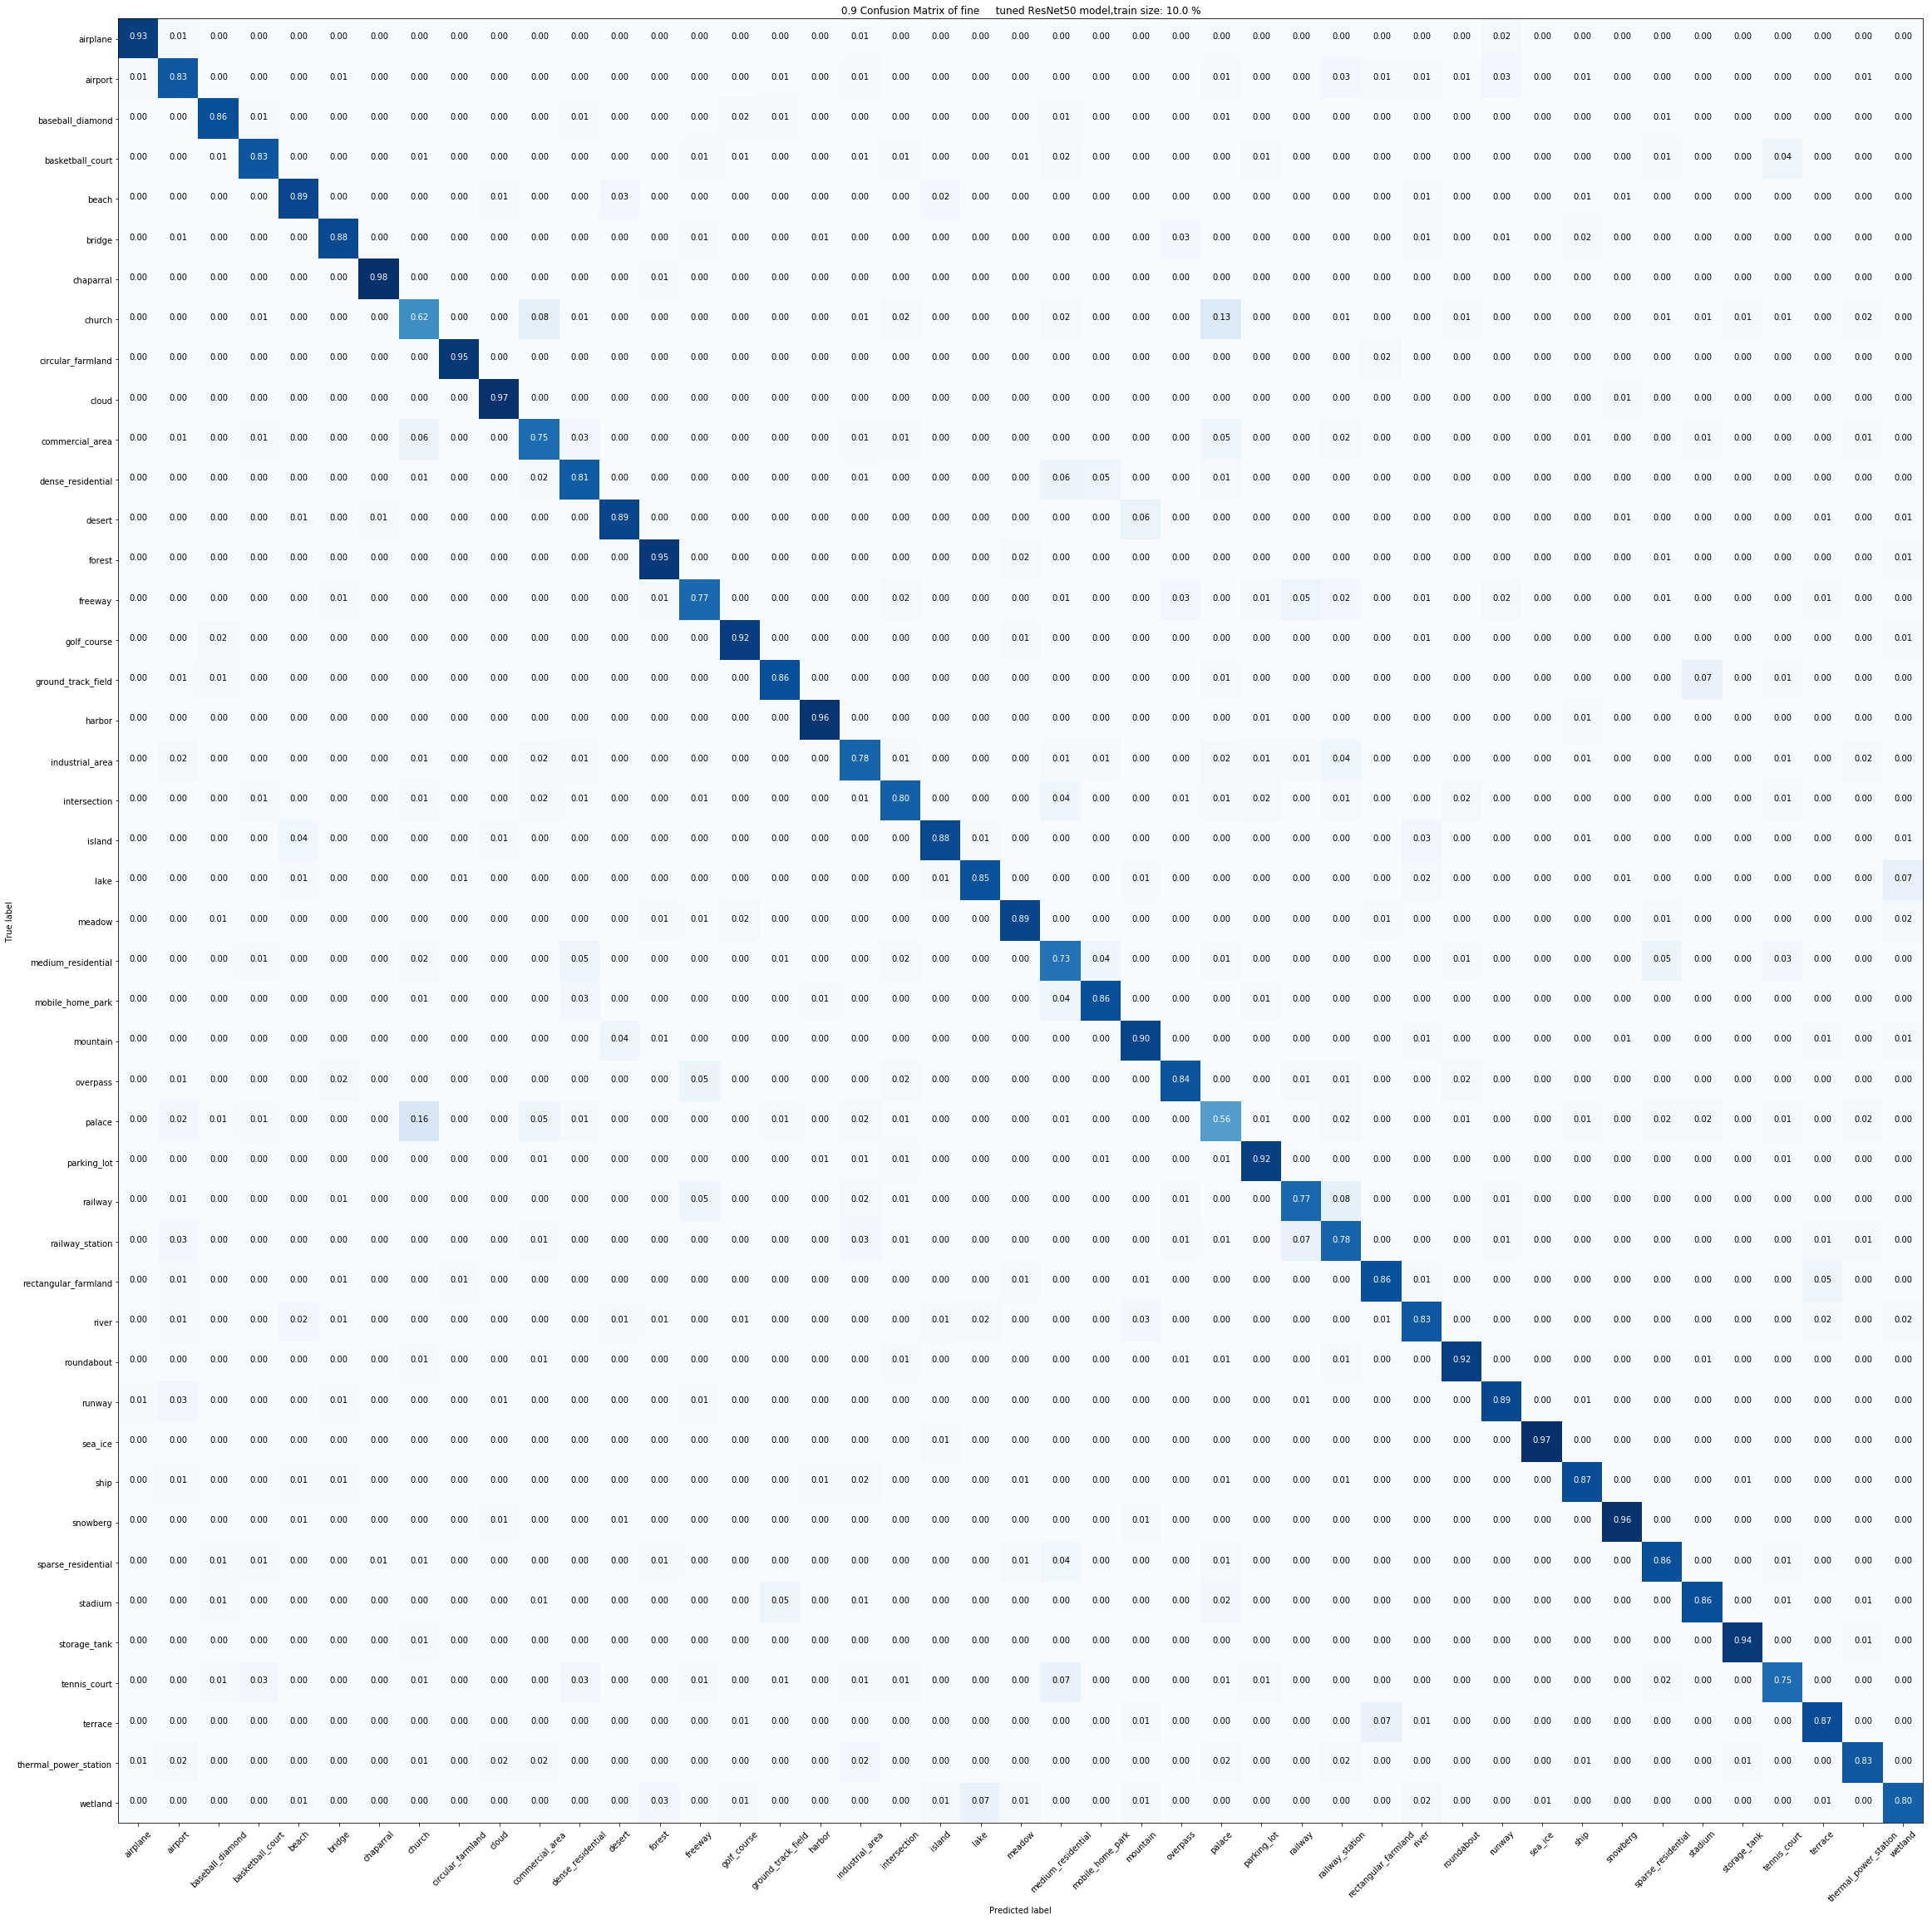

Normalized confusion matrix


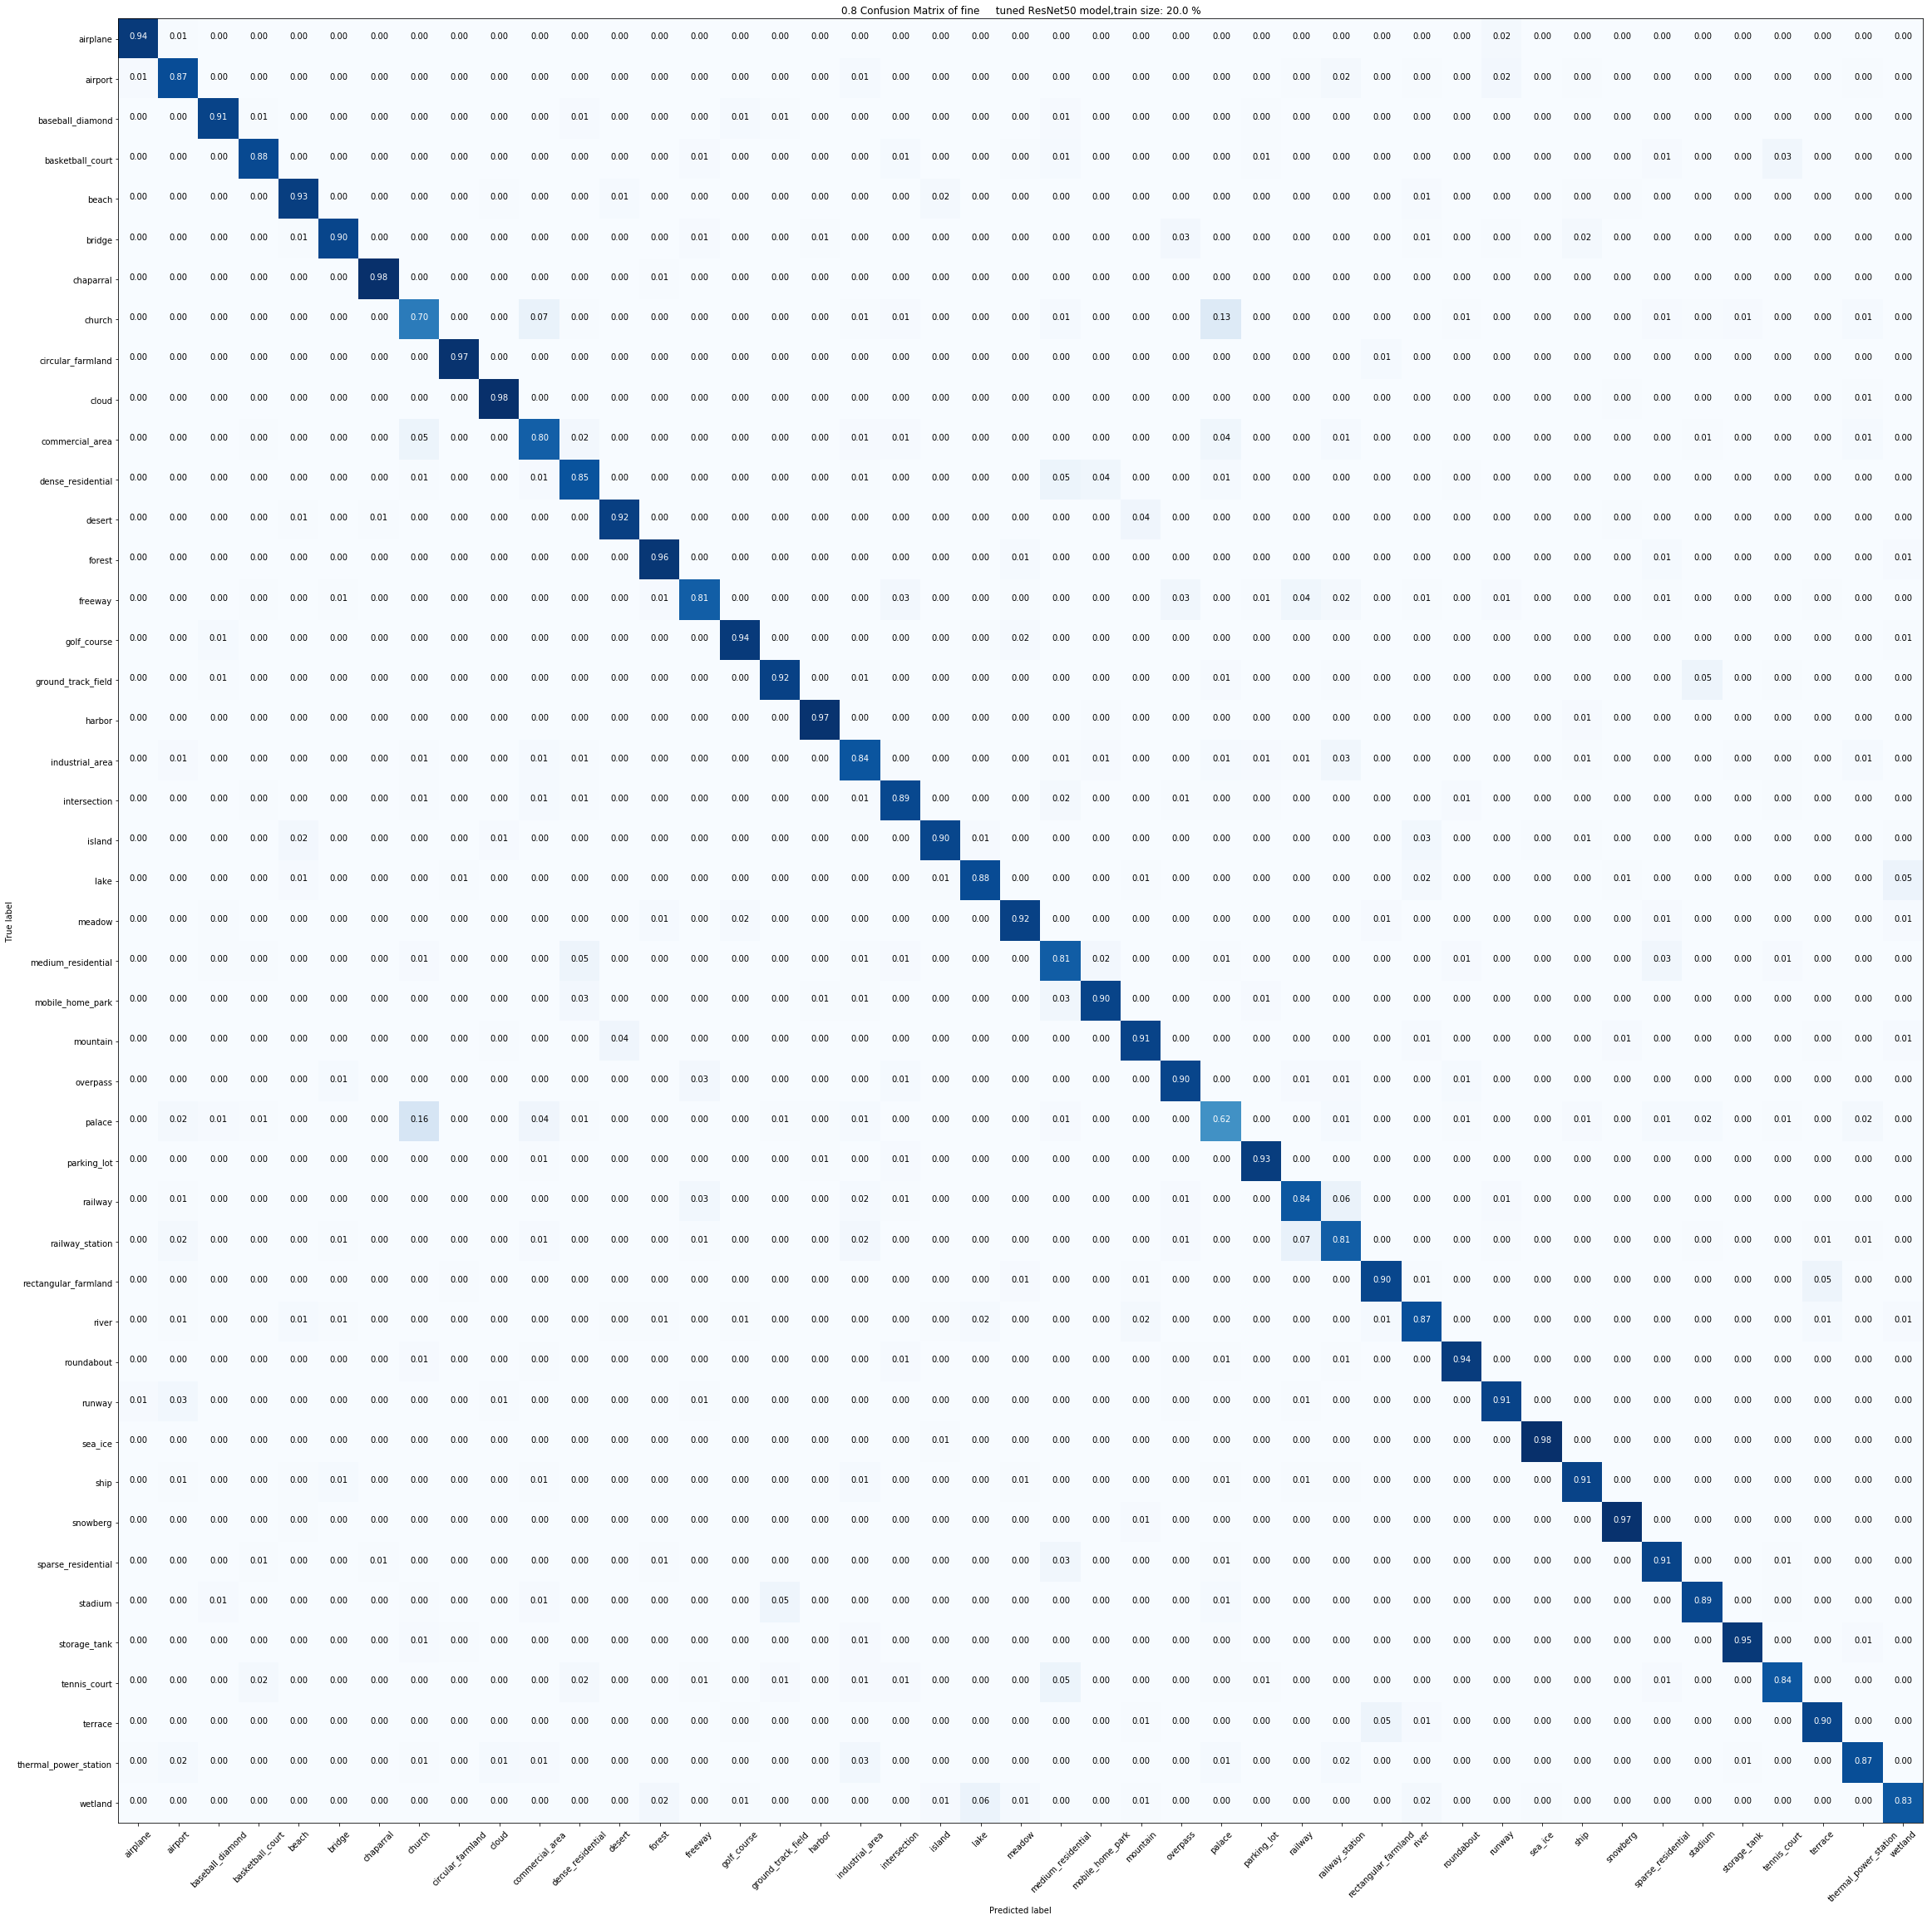

In [29]:
# plot confusion matrix
for key in accuracies.keys():
    cmfn = np.sum(confusion_matrices[key], axis=0)
    visualize.plot_confusion_matrix(cmfn, classes, normalize=True, title=key+' Confusion Matrix of fine \
    tuned ResNet50 model,'+'train size: '+str((1-float(key))*100)+ ' %')
    plt.show()